In [10]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [11]:
# inspections
insp = pd.read_csv("data/inspections.csv")

# violations
viol = pd.read_csv("data/violations.csv")

(ch:wrangling_transformations)=
# Transformations and Timestamps

Some times a feature is not in a form well suited for analysis and so we
transform it. There are many reasons a feature might need a transformation: the
value codings might not be useful for analysis; we may want to apply a mathematical function to
a feature; or we might want to pull
information out of a feature and create a new feature. We describe these three
basic kinds of transformations: type conversions, mathematical transformations,
and extractions.

Type conversion
: This kind of transformation occurs when we convert the
data from one format to another to make the data more useful for analysis. We
might convert information stored as a string to another format. For example, we
would want to convert prices reported as strings to numeric (like changing the
string `"$2.17"` to the number 2.17) so that we can compute summary statistics.
Or, we might want to convert a time stored as a string, such as
"1955-10-12", to a datetime format. Yet another example occurs when we lump
categories together, such as reducing the 11 categories for age in DAWN to 5
groupings.     

Mathematical transformation
: One kind of mathematical transformation is
when we change the units of a measurement from, say, pounds to kilograms. We
might make unit conversions so statistics on our data can be more easily
compared to others. Yet another reason to transform a feature is to
make its distribution more symmetric (this notion is covered in more detail in {numref}`Chapter %s <ch:eda>`).
The most common transformation for handling asymmetry is the logarithm. Lastly, we might want
to create a new feature from arithmetic operations on others. For example,
we can combine heights and weights to create body mass index by calculating:
$\text{height} / \text{weight}^2$. 

Extraction
: Sometimes we want to create a feature by extraction, where the new feature contains
partial information taken from another. For example, the inspection
violations consist of strings with descriptions of violations, and we may
be interested in only whether the violation is related to, say, vermin. We can
create a new feature that is `True` if the violation contains the word "vermin"
in its text description and `False` otherwise.  This conversion of information
to logical values (or 0-1 values) is extremely useful in data science. The
upcoming example in this chapter gives a concrete use-case for these binary features. 

We cover many other examples of useful transformations in {numref}`Chapter %s <ch:eda>`. 
For the rest of this section, we explain one more kind of transformation related to working with dates and times. 
Dates and times appear in many kinds of data, so it's worth learning how to work with
these data types.

## Transforming Timestamps

A *timestamp* is a data value that records a specific date and time.
For instance, a timestamp could be recorded like `Jan 1 2020 2pm` or
`2021-01-31 14:00:00` or `2017 Mar 03 05:12:41.211 PDT`.
Timestamps come in many different formats! This kind of information can be useful for analysis, 
because they let us answer questions like: "What times of day do we have the most website traffic?"
When we work with timestamps, we often need to parse them for easier analysis.

Let's take a look at an example. The inspections data frame for the San Francisco restaurants
includes the date when restaurant inspections happened:

In [3]:
insp.head(4)

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine


By default, however, `pandas` reads in the `date` column as an integer:

In [29]:
insp['date'].dtype

dtype('int64')

This storage type makes it hard to answer some useful questions about the data.
Let's say we want to know whether  inspections happen more often on the weekends or weekdays. 
To answer this question, we want to convert the `date` column to the `pandas` Timestamp
storage type and extract the day of the week.

The date values appear to come in the format: `YYYYMMDD`, where `YYYY`,
`MM`, and `DD` correspond to the four-digit year, two-digit month, and two-digit day, respectively.
The `pd.to_datetime()` method can parse the date strings into objects, where
we can pass in the format of the dates as a 
[date format](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) string:

In [3]:
date_format = '%Y%m%d'

insp_dates = pd.to_datetime(insp['date'], format=date_format)
insp_dates[:3]

0   2016-05-13
1   2017-12-11
2   2017-11-01
Name: date, dtype: datetime64[ns]

We can see that the `insp_dates` now has a `dtype` of `datetime64[ns]`, which
means that the values were successfully converted into `pd.Timestamp` objects[^datetimes].

[^datetimes]: This dtype means that Pandas uses 64 bits of memory for
    each value, and that each datetime is accurate to the nanosecond (or ns,
    for short).

:::{note}

The `pd.to_datetime()` method tries to automatically infer the timestamp format
if we don't pass in the `format=` argument. In many cases `pandas` will parse
the timestamps properly. However, sometimes the parsing doesn't output the
correct timestamps (including this case) so we must explicitly specify the
format. 

:::



`pandas` has special methods and properties for Series objects
that hold timestamps using the `.dt` accessor. For instance, we can easily pull
out the year for each timestamp:


In [5]:
insp_dates.dt.year[:3]

0    2016
1    2017
2    2017
Name: date, dtype: int64

The `pandas` documentation has the complete details on the 
[.dt accessor](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components). By
looking at the documentation, 
we see that the `.dt.day_of_week` attribute gets the day of week for each
timestamp (Monday=0, Tuesday=1, ..., Sunday=6).
So, let's assign new columns to the data frame that contain both the parsed
timestamps and the day of week: 

In [4]:
insp = insp.assign(timestamp = insp_dates, 
                   dow = insp_dates.dt.dayofweek)

insp.head(3)

,business_id,score,date,type,timestamp,dow
0,19,94,20160513,routine,2016-05-13,4
1,19,94,20171211,routine,2017-12-11,0
2,24,98,20171101,routine,2017-11-01,2


Now, we can see whether restaurant inspectors favor a certain day of the week
by grouping on the day of the week:

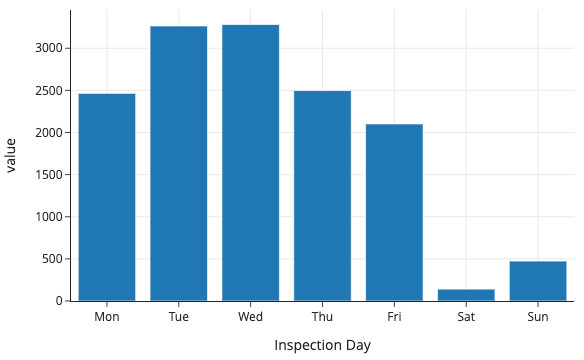

In [9]:
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fig = px.bar(insp.groupby('dow')['dow'].count(),
            height=250, width=350,)
fig.update_xaxes(ticktext=day, tickvals=np.arange(0, 7, 1),
                 title='Inspection Day')
fig.update_layout(showlegend=False)
fig.show()

As expected, inspections rarely happen on the weekend. We also find that Tuesday and Wednesday are the most popular days for an inspection. 

We have performed many wranglings on the inspections table. One approach to tracking these modifications is to pipe these actions from one to the next. We describe the idea of piping next.

## Piping for Transformations

In data analyses, we typically apply many transformations to the data, and
it is easy to introduce bugs when we repeatedly mutate a data frame,
in part because Jupyter notebooks let us run cells in any order we want. As good
practice, we recommend putting transformation code into functions with helpful
names and using the `DataFrame.pipe()` method to chain transformations
together.

Let's rewrite the timestamp parsing code above into a function and
add the timestamps back into the data frame as a new column, along with 
a second column containing the year of the timestamp:

In [10]:
date_format = '%Y%m%d'

def parse_dates_and_years(df, column='date'):
    dates = pd.to_datetime(df[column], format=date_format)
    years = dates.dt.year
    return df.assign(timestamp=dates, year=years)

Now, we can pipe the `insp` dataframe through this function using `.pipe()`:

In [11]:
insp = (pd.read_csv("data/inspections.csv")
        .pipe(parse_dates_and_years))

We can chain many `.pipe()` calls together. For example, we can extract the day of the week from the timestamps:

In [12]:
def extract_day_of_week(df, col='timestamp'):
    return df.assign(dow=df[col].dt.day_of_week)

insp = (pd.read_csv("data/inspections.csv")
        .pipe(parse_dates_and_years)
        .pipe(extract_day_of_week))
insp

,business_id,score,date,type,timestamp,year,dow
0,19,94,20160513,routine,2016-05-13,2016,4
1,19,94,20171211,routine,2017-12-11,2017,0
2,24,98,20171101,routine,2017-11-01,2017,2
...,...,...,...,...,...,...,...
14219,94142,100,20171220,routine,2017-12-20,2017,2
14220,94189,96,20171130,routine,2017-11-30,2017,3
14221,94231,85,20171214,routine,2017-12-14,2017,3


There are several key advantages of using `pipe()`. When there are many
transformations on a single dataframe, it's easier to see what transformations
happen since we can simply read the function names. Also, we can reuse
transformation functions for different dataframes. For instance, the `viol`
dataframe, which contains restaurant safety violations, also has a `date`
column.
This means we can use `.pipe()` to reuse the timestamp parsing function without
needing to write extra code. Convenient!

In [13]:
viol = (pd.read_csv("data/violations.csv")
        .pipe(parse_dates_and_years)) 
viol.head(2)

,business_id,date,description,timestamp,year
0,19,20171211,Inadequate food safety knowledge or lack of ce...,2017-12-11,2017
1,19,20171211,Unapproved or unmaintained equipment or utensils,2017-12-11,2017


A different sort of transformation changes the shape of a data frame by dropping unneeded columns, taking a subset of the rows, or rolling up the rows to a coarser granularity. We describe these structural changes next. 